In [5]:
import polars as pl

In [6]:
pexpix = pl.read_parquet('../evaluation/pexpix_v1/all_movies.parquet')

In [7]:
pixa = pl.read_parquet('../evaluation/pixa_v2/all_movies.parquet')

In [8]:
def build_frame_level_ensemble(df1: pl.DataFrame, df2: pl.DataFrame):

    df = (
        df1.rename({
            "emotion": "emotion_1",
            "confidence": "conf_1"
        })
        .join(
            df2.rename({
                "emotion": "emotion_2",
                "confidence": "conf_2"
            }),
            on=["movie", "frame_idx"],
            how="inner"
        )
    )

    # If both models agree → keep that label
    # If disagree → choose higher confidence
    df = df.with_columns(
        pl.when(pl.col("emotion_1") == pl.col("emotion_2"))
        .then(pl.col("emotion_1"))
        .otherwise(
            pl.when(pl.col("conf_1") >= pl.col("conf_2"))
            .then(pl.col("emotion_1"))
            .otherwise(pl.col("emotion_2"))
        )
        .alias("emotion")
    )

    df = df.with_columns(
        pl.max_horizontal(["conf_1", "conf_2"]).alias("confidence")
    )

    return df.select(
        "movie",
        "frame_idx",
        "emotion",
        "confidence"
    )


In [9]:
def summarize_movie_distribution(df: pl.DataFrame):

    emotions = ["angry", "fear", "happy", "sad", "surprise"]

    summary = (
        df.group_by("movie")
        .agg([
            pl.count().alias("total_faces"),
            *[
                (pl.col("emotion") == e).sum().alias(f"count_{e}")
                for e in emotions
            ]
        ])
    )

    # Convert to percentages
    for e in emotions:
        summary = summary.with_columns(
            (pl.col(f"count_{e}") / pl.col("total_faces") * 100)
            .alias(f"{e}_pct")
        )

    return summary


In [11]:
ensemble_frames = build_frame_level_ensemble(pexpix, pixa)
ensemble_movies = summarize_movie_distribution(ensemble_frames)

/tmp/ipykernel_35003/3912647190.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("total_faces"),


In [12]:
ensemble_movies.head()

movie,total_faces,count_angry,count_fear,count_happy,count_sad,count_surprise,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct
str,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64
"""lotr_2""",1241,399,275,146,375,46,32.151491,22.159549,11.764706,30.217566,3.706688
"""big_hero_6""",435,80,98,102,92,63,18.390805,22.528736,23.448276,21.149425,14.482759
"""300""",740,389,229,23,82,17,52.567568,30.945946,3.108108,11.081081,2.297297
"""hp5_order_phoenix""",850,204,206,94,258,88,24.0,24.235294,11.058824,30.352941,10.352941
"""lotr_3""",1328,305,272,161,501,89,22.966867,20.481928,12.123494,37.725904,6.701807


In [ ]:
for model, df in movie_emotion_summary_dfs.items():
    print(f"Value Count for {model} dominate emotion:")
    print(df['dominant_emotion'].value_counts())

In [13]:
ensemble_frames.write_parquet('../evaluation/ensemble/all_frames.parquet')

In [14]:
ensemble_movies.write_parquet('../evaluation/ensemble/ensemble_movies.parquet')

In [15]:
ensemble_frames.shape

(47252, 4)

In [34]:
ensemble_movies

movie,total_faces,count_angry,count_fear,count_happy,count_sad,count_surprise,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct
str,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64
"""lotr_2""",1241,399,275,146,375,46,32.151491,22.159549,11.764706,30.217566,3.706688
"""big_hero_6""",435,80,98,102,92,63,18.390805,22.528736,23.448276,21.149425,14.482759
"""300""",740,389,229,23,82,17,52.567568,30.945946,3.108108,11.081081,2.297297
"""hp5_order_phoenix""",850,204,206,94,258,88,24.0,24.235294,11.058824,30.352941,10.352941
"""lotr_3""",1328,305,272,161,501,89,22.966867,20.481928,12.123494,37.725904,6.701807
…,…,…,…,…,…,…,…,…,…,…,…
"""domino""",918,230,264,124,244,56,25.054466,28.75817,13.507625,26.579521,6.100218
"""hp4_goblet_of_fire""",942,207,341,81,218,95,21.974522,36.199575,8.598726,23.142251,10.084926
"""9""",261,19,217,11,9,5,7.279693,83.141762,4.214559,3.448276,1.915709


In [36]:
ensemble_movies = ensemble_movies.with_columns([
    pl.max_horizontal([
        "angry_pct", "fear_pct", "happy_pct", "sad_pct", "surprise_pct"
    ]).alias("max_pct"),
])

In [37]:
ensemble_movies = ensemble_movies.with_columns([
    pl.when(pl.col("angry_pct") == pl.col("max_pct")).then(pl.lit("angry"))
        .when(pl.col("fear_pct") == pl.col("max_pct")).then(pl.lit("fear"))
        .when(pl.col("happy_pct") == pl.col("max_pct")).then(pl.lit("happy"))
        .when(pl.col("sad_pct") == pl.col("max_pct")).then(pl.lit("sad"))
        .when(pl.col("surprise_pct") == pl.col("max_pct")).then(pl.lit("surprise"))
        .alias("dominant_emotion")
    ])

In [39]:
ensemble_movies['dominant_emotion'].value_counts()

dominant_emotion,count
str,u32
"""happy""",3
"""sad""",16
"""angry""",21
"""fear""",19


In [19]:
import pandas as pd

In [22]:
EMOTION_COLORS = {
    "angry": "#E74C3C",
    "fear": "#7F8C8D",
    "happy": "#FFD93D",
    "sad": "#4A90E2",
    "surprise": "#9B59B6",
}

perc_cols = ["angry_pct", "fear_pct", "happy_pct", "sad_pct", "surprise_pct"]

In [23]:
def get_tidy(df):
    pd_df = df.to_pandas()
    tidy = pd.melt(pd_df, id_vars=["movie"], value_vars=perc_cols,
        var_name="emotion", value_name="percent")
    tidy['emotion'] = tidy['emotion'].str.removesuffix('_pct')
    tidy.sort_values(by=["movie"], inplace=True)
    return tidy

In [24]:
tidy = get_tidy(ensemble_movies)

In [29]:
import plotly.express as px
import plotly.graph_objects as go

In [30]:
def stacked_emo_perc_by_movie(tidy_df, save_path=None, name="Model"):
    fig = px.bar(
        tidy_df,
        x="movie",
        y="percent",
        color="emotion",
        color_discrete_map=EMOTION_COLORS,
        barmode="stack",
        title=f"{name}: Emotion Distribution by Movie (Stacked %)",
        height=600,
        category_orders={
            "emotion": ["angry", "fear", "happy", "sad", "surprise"]
        },
    )

    fig.update_xaxes(tickangle=45)
    fig.update_layout(
        legend=dict(
            orientation="h", yanchor="bottom", 
            y=.99, xanchor="center", x=0.5,
            bordercolor="#000000",
            borderwidth=2, 
        )
    )
    
    if save_path:
        save_name = f"{name}_stack_emo_by_movie.png"
        fig.write_image(save_path / save_name)
    fig.show()

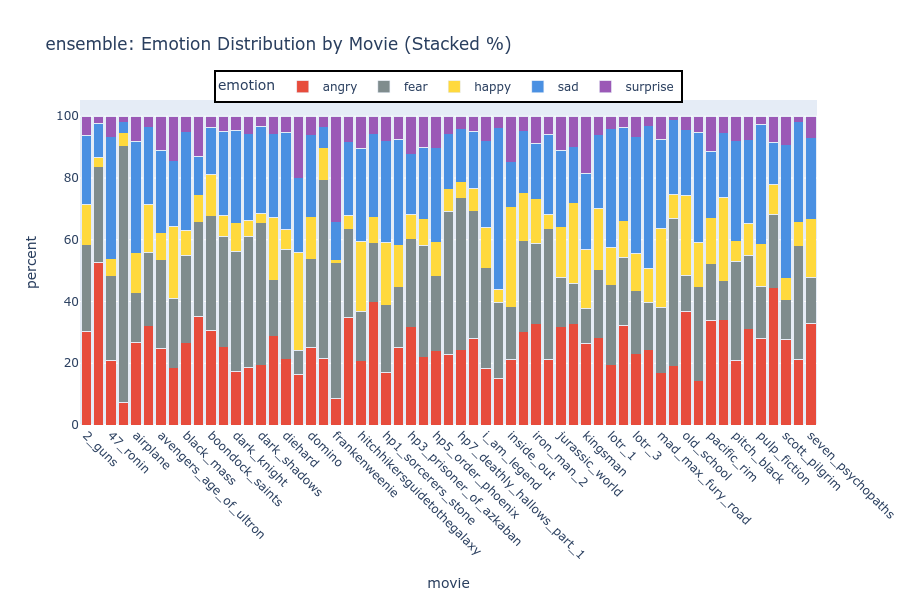

In [31]:
stacked_emo_perc_by_movie(tidy, save_path=None, name='ensemble')

In [32]:
raf = pl.read_parquet("../evaluation/raf/movie_emotion_summary.parquet")
best = pl.read_parquet("../evaluation/pixa_v2/movie_emotion_summary.parquet")

In [33]:
raf.head()

movie,count_fear,count_happy,count_sad,count_surprise,count_angry,avg_conf_fear,avg_conf_happy,avg_conf_sad,avg_conf_surprise,avg_conf_angry,avg_rel_face_area_fear,avg_rel_face_area_happy,avg_rel_face_area_sad,avg_rel_face_area_surprise,avg_rel_face_area_angry,total_faces,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,max_pct,dominant_emotion
str,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,str
"""real_steel""",37,143,185,274,53,0.714483,0.754018,0.78859,0.836901,0.770083,0.072923,0.075881,0.090038,0.072787,0.070398,692,7.65896,5.346821,20.66474,26.734104,39.595376,39.595376,"""surprise"""
"""point_break""",14,225,278,304,105,0.620893,0.784103,0.798621,0.838821,0.767103,0.078656,0.106487,0.117347,0.12276,0.106894,926,11.339093,1.511879,24.298056,30.021598,32.829374,32.829374,"""surprise"""
"""jurassic_world""",27,124,219,377,83,0.636673,0.814129,0.83496,0.875711,0.769752,0.068134,0.068042,0.098071,0.077066,0.066062,830,10.0,3.253012,14.939759,26.385542,45.421687,45.421687,"""surprise"""
"""iron_man_3""",78,147,296,278,106,0.707522,0.774665,0.799249,0.804156,0.724956,0.121488,0.101751,0.111957,0.102359,0.142152,905,11.712707,8.618785,16.243094,32.707182,30.718232,32.707182,"""sad"""
"""lotr_3""",34,161,672,359,102,0.698041,0.816314,0.86317,0.827439,0.716106,0.113534,0.150577,0.160955,0.156604,0.182803,1328,7.680723,2.560241,12.123494,50.60241,27.033133,50.60241,"""sad"""


In [ ]:
df_map = {
    "raf": raf,
    "best": best,
    "ensemble": tidy
}

In [ ]:
all_results = []

for model_name, model_df in movie_emotion_summary_dfs.items():
    all_results.append(
        summarize_movie_extremes(model_name, model_df, n=3)
    )

final_df = pl.concat(all_results)

In [1]:
import polars as pl

In [6]:
all_movies = pl.read_parquet('../evaluation/pexpix_v1/movies/2_guns.parquet')

In [7]:
all_movies.head()

movie,frame_idx,timestamp_sec,face_area,relative_face_area,emotion,confidence
str,i64,f64,i64,f64,str,f64
"""2_guns""",700,29.195759,101761,0.397008,"""sad""",0.801103
"""2_guns""",1700,70.903986,12544,0.048939,"""happy""",0.991839
"""2_guns""",2300,95.928922,9604,0.037469,"""angry""",0.575834
"""2_guns""",3000,125.124681,11025,0.043013,"""sad""",0.821578
"""2_guns""",3300,137.637149,13225,0.051596,"""sad""",0.892647


In [4]:
all_movies.shape

(47252, 8)

In [5]:
all_movies.columns

['movie',
 'frame_idx',
 'timestamp_sec',
 'face_area',
 'relative_face_area',
 'emotion',
 'confidence',
 'face_size_category']